# Final Project Submission

- Student name: Kristen Tokunaga
- Student pace: part time
- Scheduled project review date/time: 
- Instructor name: Brandon Lewis
- Blog post URL: https://kristentaytok.github.io/

# The Scientific Method

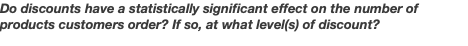

Using data from the Northwind database, we will employ SQL, statistical analysis (hypothesis testing), and the Scientific Method to answer business questions about this fictional company:

1. Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?
2. Is there a statistically significant difference in performance between employees from the 52 territories?  
3. Does the spend of our top 20% of customers exceed 80% of our sales income of in a given year?
4. Which product categories had significantly higher orders per quarter? 

The process for answering the 4 above questions will be to follow the steps from the Scientific method:
1. Construct hypothesis (null and alternative)
2. Test with an experiment: one-tail or two-tail test
3. Analyze Results: 
- Test statistic
- P-value
- Effect size
4. Conclusion: Reject or fail to reject the hypothesis

# Getting Started

1. Import Necessary Libraries
2. Connect to the Database
3. Explore the Data

In [18]:
#import libraries
import sqlalchemy
import pandas as pd
import numpy as np



import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

In [19]:
#connect using SQLAlchemy, an Object Relational Mapper (ORM) which connects relational database tables to Python objects, and use CRUD: Create, Read, Update, Delete
#create an engine object, and bind it to our database
from sqlalchemy import create_engine
engine = create_engine('sqlite:///Northwind_small.sqlite', echo=True)

#create an inspector object by passing in engine to inspect
from sqlalchemy import inspect
inspector = inspect(engine)

# get names of tables in database
print(inspector.get_table_names())

#get column names for a specific table, along with each column's datatype
def get_columns_info(table_name):    
    """ Function takes in table name and prints columns' names
    and datatypes """
    
    cols_list = inspector.get_columns(table_name)    
    print(f"Table Name: {table_name}\n")
    for col in cols_list:
        print(f"Name: {col['name']} \t Type: {col['type']}")
              
get_columns_info('OrderDetail')
#https://github.com/BrittaInData/dsc-2-final-project-online-ds-ft-100118/blob/master/01_Final_Notebook.ipynb

2019-06-04 07:47:52,303 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-06-04 07:47:52,304 INFO sqlalchemy.engine.base.Engine ()
2019-06-04 07:47:52,305 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-06-04 07:47:52,306 INFO sqlalchemy.engine.base.Engine ()
2019-06-04 07:47:52,307 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-06-04 07:47:52,308 INFO sqlalchemy.engine.base.Engine ()
['Category', 'Customer', 'CustomerCustomerDemo', 'CustomerDemographic', 'Employee', 'EmployeeTerritory', 'Order', 'OrderDetail', 'Product', 'Region', 'Shipper', 'Supplier', 'Territory']
2019-06-04 07:47:52,310 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("OrderDetail")
2019-06-04 07:47:52,310 INFO sqlalchemy.engine.base.Engine ()
Table Name: OrderDetail

Name: Id 	 Type: VARCHAR(8000)
Name: OrderId 	 Type: INTEGER
Name: ProductId 	 Type: INT

In [20]:
#explore the data
table_list = ['Category', 'Customer', 'CustomerCustomerDemo', 'CustomerDemographic', 'Employee', 'EmployeeTerritory', 'Order', 'OrderDetail', 'Product', 'Region', 'Shipper', 'Supplier', 'Territory']
def all_tables(table_list):
    for table in table_list:
        print(get_columns_info(table))
all_tables(table_list)

from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "Northwind_ERD.png")

2019-06-04 07:47:54,669 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Category")
2019-06-04 07:47:54,670 INFO sqlalchemy.engine.base.Engine ()
Table Name: Category

Name: Id 	 Type: INTEGER
Name: CategoryName 	 Type: VARCHAR(8000)
Name: Description 	 Type: VARCHAR(8000)
None
2019-06-04 07:47:54,672 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Customer")
2019-06-04 07:47:54,673 INFO sqlalchemy.engine.base.Engine ()
Table Name: Customer

Name: Id 	 Type: VARCHAR(8000)
Name: CompanyName 	 Type: VARCHAR(8000)
Name: ContactName 	 Type: VARCHAR(8000)
Name: ContactTitle 	 Type: VARCHAR(8000)
Name: Address 	 Type: VARCHAR(8000)
Name: City 	 Type: VARCHAR(8000)
Name: Region 	 Type: VARCHAR(8000)
Name: PostalCode 	 Type: VARCHAR(8000)
Name: Country 	 Type: VARCHAR(8000)
Name: Phone 	 Type: VARCHAR(8000)
Name: Fax 	 Type: VARCHAR(8000)
None
2019-06-04 07:47:54,677 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("CustomerCustomerDemo")
2019-06-04 07:47:54,678 INFO sqlalchemy.

# Question #1: Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?

1. Construct hypothesis (null and alternative)
- Null: H0 = there is no difference in product quantity per order across all levels of discounts (M1 = M2 = M3 = M4 = M5 = M6 = M7 = M8 = M9 = M10 = M11)
- Alternative: H1 = there is a difference in product quantity per order between at least 2 discount levels (M1 =/= M2 and/or M3, etc.; M2 =/= M3 and/or M4, etc.) 
2. Test with an experiment: two-tail test (because we want to test if the average product quantity per order at each discount level falls between, or outside of, a range of two given values; in short, we are testing for any difference [more or fewer products per order] among the discount levels.  
- ANOVA  (ANalysis Of VAriance) = a statistical test for multiple groups (multiple pairwise comparisons). ANOVA describes overall variation from all of our sample observations, and break this variation down to variation from each of these individual factors [Sum of Square of Deviations. or the variance between mean of each sample group to the observations within the group itself] vs. unaccounted-for error or chance [Sum of Square of Errors, or the variance between mean of these test groups to the mean of all observations].    
3. Analyze Results: 
- Test statistic = F-distribution, which results from comparing the SSD and SSE. Higher values of the F-statistic indicate a higher probability of that factor being influential. If we set alpha (significance level) = 0.05, and F > F_alpha, then the factor has a significant effect on the dependent variable. 
- P-value = the calculated probability of arriving at this data randomly (proability that sample means are the same). In the ANOVA test we will use, this is reflected in the PR(>F) value. 
- Effect size = the size in difference between two groups under observation. This is highly valuable in quantifying the effectiveness of a particular intervention, showing how well the test model works in a range of practical contexts and allowing us to perform a power analysis to determine the sample size needed to achieve a certain probability of finding a true effect (if present). This is most commonly measured using Cohen's D. A larger value represents a greater difference between two groups on that variable.  
4. Conclusion: Reject or fail to reject the hypothesis

In [46]:
#using the pd.read_sql_query() method is the better way to incorporate the SQL data tables into pandas because by passing through 1. the SQL query we want to execute (in the form of a string) and 2. the engine object we created to connect to our database with SQLAlchemy, the columns will be labeled correctly (instead of being assigned index column numbers) 
df_territory = pd.read_sql_query('''SELECT * FROM Territory''', engine)
df_territory.TerritoryDescription.unique()

2019-06-05 05:06:05,000 INFO sqlalchemy.engine.base.Engine SELECT * FROM Territory
2019-06-05 05:06:05,002 INFO sqlalchemy.engine.base.Engine ()


array(['Westboro', 'Bedford', 'Georgetow', 'Boston', 'Cambridge',
       'Braintree', 'Providence', 'Hollis', 'Portsmouth', 'Wilton',
       'Morristown', 'Edison', 'New York', 'Mellvile', 'Fairport',
       'Philadelphia', 'Neward', 'Rockville', 'Greensboro', 'Cary',
       'Columbia', 'Atlanta', 'Savannah', 'Orlando', 'Tampa',
       'Louisville', 'Beachwood', 'Findlay', 'Southfield', 'Troy',
       'Bloomfield Hills', 'Racine', 'Roseville', 'Minneapolis',
       'Hoffman Estates', 'Chicago', 'Bentonville', 'Dallas', 'Austin',
       'Denver', 'Colorado Springs', 'Phoenix', 'Scottsdale',
       'Santa Monica', 'Menlo Park', 'San Francisco', 'Campbell',
       'Santa Clara', 'Santa Cruz', 'Bellevue', 'Redmond', 'Seattle'],
      dtype=object)

In [55]:
#using the pd.read_sql_query() method is the better way to incorporate the SQL data tables into pandas because by passing through 1. the SQL query we want to execute (in the form of a string) and 2. the engine object we created to connect to our database with SQLAlchemy, the columns will be labeled correctly (instead of being assigned index column numbers) 
df_orderdetail = pd.read_sql_query('''SELECT * FROM OrderDetail''', engine)
print(df_orderdetail.Discount.value_counts())
print(df_orderdetail.info())

2019-06-05 05:34:14,165 INFO sqlalchemy.engine.base.Engine SELECT * FROM OrderDetail
2019-06-05 05:34:14,166 INFO sqlalchemy.engine.base.Engine ()
0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Id           2155 non-null object
OrderId      2155 non-null int64
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB
None


Out of the 11 discount levels, 5 were rarely used: 0.03, 0.02, 0.01, 0.04, and 0.06. Because of the low sample sizes for these groupings, we will drop these outliers.

In [65]:
df_orderdetail = df_orderdetail[(df_orderdetail.Discount == 0.00) | (df_orderdetail.Discount == 0.05) | (df_orderdetail.Discount == 0.10) | (df_orderdetail.Discount == 0.20) | (df_orderdetail.Discount == 0.15) | (df_orderdetail.Discount == 0.25)]
#https://stackoverflow.com/questions/29017525/deleting-rows-based-on-multiple-conditions-python-pandas

In [69]:
print(df_orderdetail.Discount.value_counts())
df_orderdetail.head()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
Name: Discount, dtype: int64


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


ANOVA tests require 3 assumptions to be met before its results can be considered accurate and trustworthy. These 3 assumptions are similar to those of linear regression: 
1. Normality
2. Homogeneity of variance
3. Independent observations (i.e., no multicolinearity)

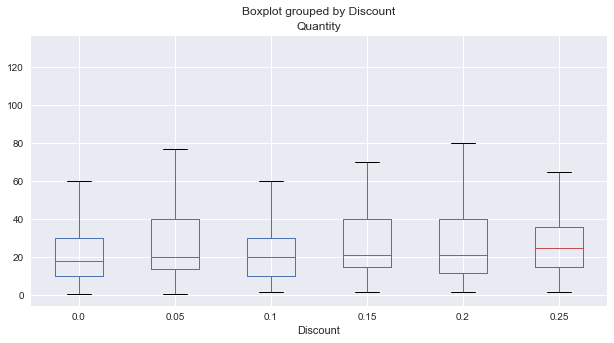

In [79]:
df_orderdetail.boxplot('Quantity', by='Discount', figsize=(10, 5));
#The boxplots below give us a sense of whether there are outliers present within or between the different discount groups. ANOVA compares the between-group vs. within-group variance; if the between-group variance is greater than the within-group variance, then we tend to have a significant effect. The vertical height of each box and whisker = within-group variance, while comparing the medians of each box plot to the horizontal comparators gives a visual representation of between-group variance. 

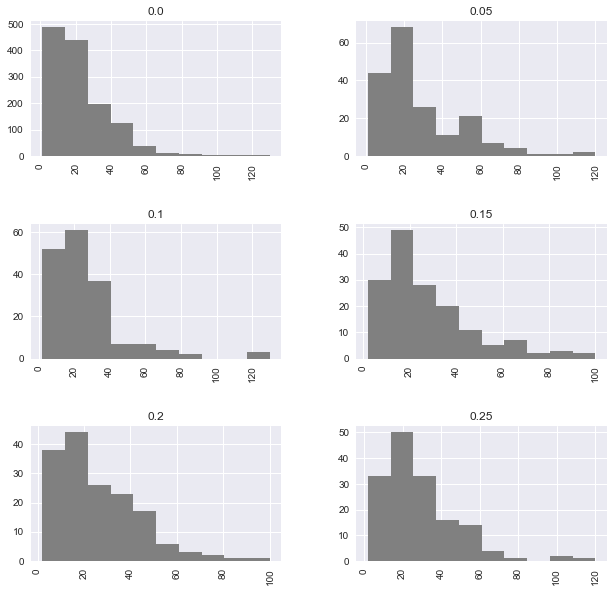

In [78]:
df_orderdetail.hist('Quantity', by='Discount', figsize=(10, 10), color='grey');
#The histograms below provide a visual depiction of the normality (or lackthereof) of the data within each discount group

In [80]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
anova = ols('Quantity ~ Discount', data = df_orderdetail).fit()
table = sm.stats.anova_lm(anova, typ=2)
print(table)
anova.summary()
#The overall effect of discount is seen in the "Discount" row of the ANOVA table: the sum_sq (sum of squares) is how much variance is explained by our model of Discount's effect on quantity of products ordered. Based on the high F value and low p-value (< 0.05), we can see that the current model (discount) explains a significant amount of variance and there is a high probability that this factor is influential. - https://pythonfordatascience.org/anova-python/ This can also be confirmed by the skewness and kurtosis in the summary, which factor into the JB calculation.
#The diagnostics in the OLS regression summary help test our assumptions:
#1. Jarque-Bera tests for normality: The null hypothesis for this test is that the data is normally distributed, and a small p-value with a large chi-square value means that you can reject the null hypothesis that the data is normally distributed. - https://www.statisticshowto.datasciencecentral.com/jarque-bera-test/ Fortunately, ANOVA is robust to data that violates the assumption of normality, especially when there is a large sample size and group sizes are approximately equal. 
#2. Omnibus tests the homogeneity of variance: The omnibus test is a likelihood-ratio chi-square test of the current model versus the null (in this case, intercept) model. The significance value of less than 0.05 indicates that the current model outperforms the null model. - https://www.ibm.com/support/knowledgecenter/en/SS3RA7_sub/modeler_tutorial_ddita/spss/tutorials/genlin_ships_omnibus.html. This can also be tested using Levene's test for homogeneity of variance, which is concerned with whether or not the variance of each group is significantly different (from one another).  
#3. Condition Number tests for multicolinearity: because this value is < 20, there is low multicolinearity - https://pythonfordatascience.org/anova-python/
#The OLS summary also provides other useful information, such as the model's intercept (mean of the baseline group) and the coefficients (difference between the mean of the control group and the Discount group)

                 sum_sq      df          F        PR(>F)
Discount   12621.238965     1.0  35.487951  2.991487e-09
Residual  762866.181622  2145.0        NaN           NaN


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Quantity   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     35.49
Date:                Wed, 05 Jun 2019   Prob (F-statistic):           2.99e-09
Time:                        06:25:49   Log-Likelihood:                -9351.1
No. Observations:                2147   AIC:                         1.871e+04
Df Residuals:                    2145   BIC:                         1.872e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     22.2628      0.491     45.374      0.000      21.301      23.225
Discount      29.0137      4.870      5.957      0.000      19.463      38.565
==============================================================================
Omnibus:                      793.193   Durbin-Watson:                   1.642
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3134.102
Skew:                           1.787   Prob(JB):                         0.00
Kurtosis:                       7.718   Cond. No.                         12.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [81]:
#Levine's test: This test is a better way to test for homogeneity of variance because: 1. it is more robust in cases where the data is not normally distributed and 2. it tests the homogeneity of variance assumption for each level of the categorical variable (while the statsmodel diagnostic Omnibus test checks for homogeneity of variance across the whole dataset). - https://pythonfordatascience.org/anova-python/
from scipy import stats
stats.levene(df_orderdetail['Quantity'][df_orderdetail['Discount'] == 0.00],
             df_orderdetail['Quantity'][df_orderdetail['Discount'] == 0.05],
             df_orderdetail['Quantity'][df_orderdetail['Discount'] == 0.10],
             df_orderdetail['Quantity'][df_orderdetail['Discount'] == 0.15],
             df_orderdetail['Quantity'][df_orderdetail['Discount'] == 0.20],
             df_orderdetail['Quantity'][df_orderdetail['Discount'] == 0.25])
#With a p-value < 0.05, the test result is significant which indicates the groups do not have equal variances. This means that the assumption of homogeneity of variance is violated and we cannot have confidence in the omnibus F test results. To be more specific, we could not be confident that the observed mean differences were attributable to the conditions of each group or if those differences were attributable to individual by treatment interaction effects (also called a subject by treatment interaction). However, the relatively equal group sizes helps make the ANOVA test and resulting F-statistic more robust in cases of (i.e., less sensitive to the effects of) violations to this assumption and corrections are not necessary.

LeveneResult(statistic=2.9943951679841643, pvalue=0.010664285577385134)

In [84]:
#calculate effect size
control = df_orderdetail[df_orderdetail['Discount']==0]['Quantity']
experimental = df_orderdetail[df_orderdetail['Discount']!=0]['Quantity']

def Cohen_d(group1, group2):

    diff = group1.mean() - group2.mean()
    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()
    # Calculate the pooled threshold
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    return abs(d)

Cohen_d(experimental, control)

#Interpration of Cohen's D: Small effect = 0.2, medium effect = 0.5, large effect = 0.8


0.29970787209408895

While the ANOVA test F-statistic indicates that discount does have an effect on quantity of products ordered, to answer the question of "which levels of discount have an effect on quantity of products ordered" we need to be able to calculate differences between discount levels. ANOVA is an omnibus test, meaning it can only capture total differences among the variable groups. Post-hoc testing is required to determine which groups actually had a significant difference. 

Reject Null Hypothesis


/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


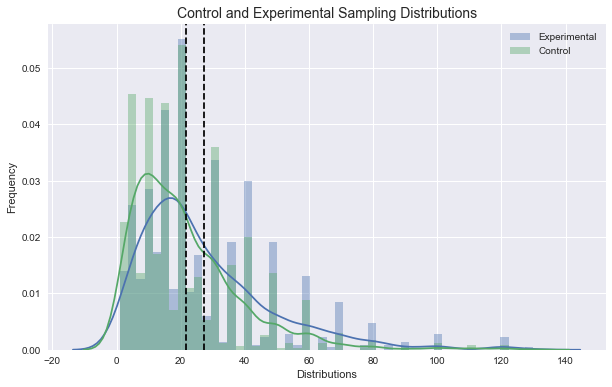

# Conclusion

# Future Directions